In [138]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [139]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [140]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [141]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo = False)

In [142]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [143]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [144]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [145]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [146]:
inspector = inspect(engine)
columns_meas = inspector.get_columns('measurement')
columns_stat = inspector.get_columns('station')

print("Measurement Columns")
print("-----------")
for column in columns_meas:
    print(column["name"], column["type"])
print("-----------")
print("Station Columns")
print("-----------")
for column in columns_stat:
    print(column["name"], column["type"])

Measurement Columns
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
Station Columns
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [147]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
print(f"Most recent date: {most_recent_date}")

Most recent date: 2017-08-23


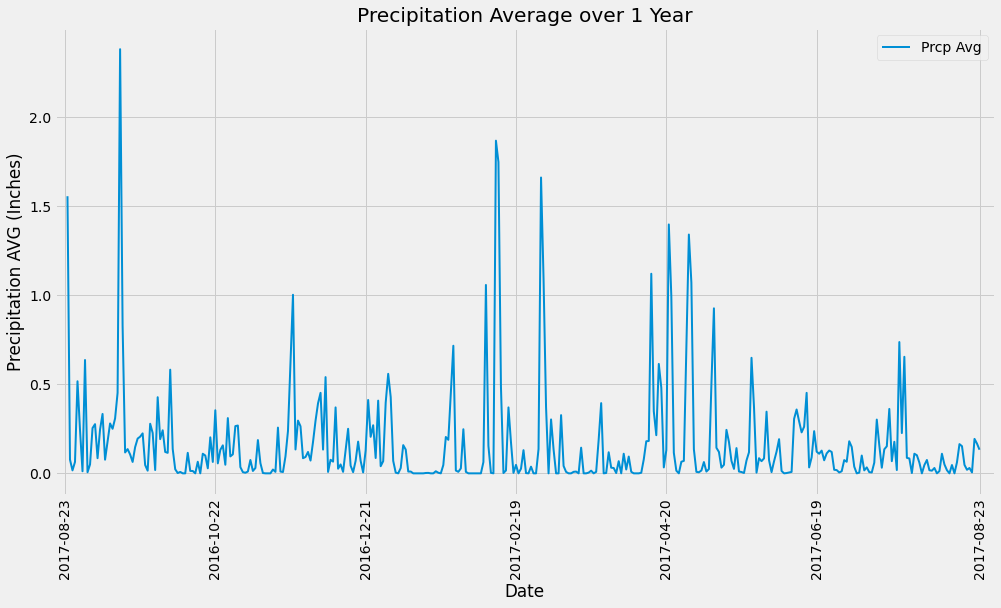

In [148]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# strptime converts strings into datetime
# subtract 365 days to find 1 year ago

most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
year_ago = most_recent_date_dt - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
# From the describe there was 2000+ count, multiple rows for the same date
# Took the average of each day and grouped by date

prcp_data = session.query(measurement.date, func.avg(measurement.prcp)).\
    filter(measurement.date >= year_ago).\
    group_by(measurement.date).all()


# prcp_data = session.query(measurement.date, measurement.prcp).\
#     filter(measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns = ['Date', 'Prcp Avg'])
df.set_index('Date', inplace = True)


# Sort the dataframe by date
sorted_df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
# I plotted the data using a line pot of the average precipitation
# Put the x ticks as 60 day intervals

sorted_df.plot(linewidth=2, xticks=(-1, 59, 119, 179, 239, 299, 364), figsize=(15,8), rot = 90)
plt.xlim(-5, 370)
plt.ylabel("Precipitation AVG (Inches)")
plt.title("Precipitation Average over 1 Year")
plt.show()


In [149]:
# Use Pandas to calcualte the summary statistics for the precipitation data

sorted_df.describe()

,Prcp Avg
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [150]:
# Design a query to calculate the total number stations in the dataset
station_query = session.query(station.station).count()
station_query

9

In [151]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_station_query = session.query(measurement.station, func.count(measurement.station))\
                        .group_by(measurement.station)\
                        .order_by(func.count(measurement.station).desc()).all()
active_station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [152]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'

tobs_query = session.query(measurement.station, \
                           func.min(measurement.tobs), \
                           func.max(measurement.tobs), \
                           func.avg(measurement.tobs)).\
                           filter(measurement.station == station_id).all()
tobs_query

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [153]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

year_query = session.query(measurement.date, measurement.tobs).\
                           filter(measurement.date >= year_ago).\
                           filter(measurement.station == station_id).all()
year_query

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

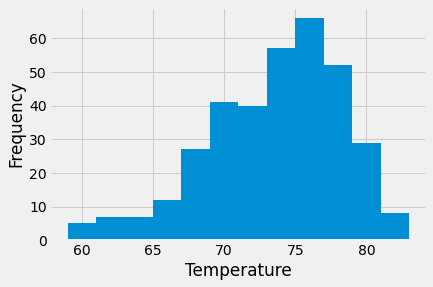

In [154]:
# Plot the results as a histogram with bins=12.

df2 = pd.DataFrame(year_query, columns = ['Date', 'Tobs'])
df2.set_index('Date', inplace = True)

plt.hist(df2['Tobs'], bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()

# Close session

In [155]:
# Close Session
session.close()